# Connect the notebook (colab) to my drive

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


# Packages and requirements

In [ ]:
import pandas as pd

In [ ]:
from models import FFDNet

In [ ]:
import matplotlib.pyplot as plt

import os 
import sys
from  PIL import Image
from skimage import io
from skimage import color
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import cv2
import time
from skimage.measure.simple_metrics import compare_psnr # to compute psnr 

In [ ]:
import warnings
warnings.simplefilter("ignore")

In [ ]:
# package for 1D waar transform and split image into patchs
# ignore warmings
! pip install PyWavelets==0.2.2
! pip install patchify

In [ ]:

import pywt
from patchify import patchify, unpatchify

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()

# Data (*Set12*)

In [ ]:

%cd /content/drive/MyDrive/M2_MVA/ImagerieNumerique/Project_imagerie

/content/drive/MyDrive/M2_MVA/ImagerieNumerique/Project_imagerie


In [ ]:
# the patch to images
# please set  the image path to the directory set12 
pathims = '/content/drive/MyDrive/M2_MVA/ImagerieNumerique/Project_imagerie/set12'

In [ ]:
img1 = io.imread(pathims+'/01.png')
img1 = img1/255. # we scale the image (0,255) ==> to (0, 1)

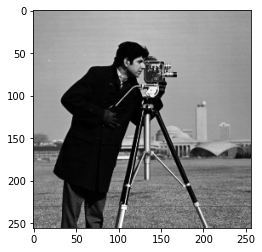

In [ ]:
plt.imshow(img1 , cmap='gray')
plt.show()

In [ ]:
#img_nois = img  + np.random.randn(img.shape[0], img.shape[1] )

# BM & NLF

## Utils

In [ ]:
def patchif(img,kernel= (3, 3), step = 1 ):
  """
  split an image in patches using patchify function 
  """
  return patchify(img, patch_size = kernel, step= step)

In [ ]:
def norm2dist(patchA, patchB):
  """"
  Computes the distance between two patches
  """
  A_B = patchA - patchB
  dist = 0

  return np.sqrt(np.sum(A_B**2))

In [ ]:
def simpatch(patches, indice = [0,0],  N2_max = 32):
  """
  determines the similar patches of patch located at the position indice
  N2_max: the number of similar patches to retain
  indice: position of patch of interest
  """

  ind0 = indice[0]
  ind1 = indice[1]
  p_ref = patches[ind0, ind1]
 
  nw = patches.shape[1]
  nh = patches.shape[0]
  dist_others = np.zeros((nh, nw))
  
  for h in range(nh):
    for w in range(nw):
      if (h == ind0 and w == ind1):
        dist_others[h,w] = np.inf
      else:
        dist_others[h, w] = norm2dist(p_ref, patches[h,w])

  mins = dist_others.flatten().argsort()[:N2_max]
  rows = list(mins//nw)
  colums = list(mins%nw)

  rows.append(ind0)
  colums.append(ind1)

  array_indices = np.array([rows, colums])
  return array_indices.T

In [ ]:
def shrinkage_operator(q,tho):
    """
    This function computes the shrinkage operator for the NLF filtering.
    :param tho: is the treshold
    """
    q_2 = q**2
    return q * q_2/(q_2 + tho**2)

In [ ]:
def BM(patches, N2_max = 32, verbose = False):
  """
  Do the block matching given array of patches
  : param  the array obtained after spliting the image into patchs
  :param N2_max: the maximal number of patches in a block. We add +1 for the reference patch

  """
  start = time.time()
  S = {'block':[], 'indice':[]}
  
  I, J = patches.shape[0], patches.shape[0]
  for i in range(I):
    for j in range(J):
      if verbose:
        print(i, j)
      block = np.zeros((10, 10, N2_max +1))
      block_inds = simpatch(patches, indice = [i,j],  N2_max = N2_max)

      for ind in range(N2_max+1):
        block[:,:,ind] = patches[block_inds[ind][0], block_inds[ind][1] ]
      S['block'].append(block)
      S['indice'].append(block_inds)
  tim = time.time() - start
  if verbose:
    print(tim)
  return S

In [ ]:
def haar_wavelet(G, tho_k):
    """
    This function compute the haar wavelet and apply the shrinkage operator
    """
    CA,CD = pywt.dwt(G, 'haar')

    g_j_t = np.concatenate([CA, CD], axis = -1)
    g_j_t2 = g_j_t**2
    tmp = g_j_t2/(g_j_t2 + tho_k**2)
    w_jk = 1/(np.sum(tmp**2))


    CA , CD = shrinkage_operator( CA, tho_k),shrinkage_operator(CD,tho_k)     
    #wav = CA,CD

    # compute the weights

    return w_jk*pywt.idwt(CA,CD,'haar')[:,:,:-1], w_jk

In [ ]:
def apply1dShrink(S,tho_k= 0.5):
  

  S['weights'] = []
  S['reconswblock'] = []
  for j, gj_tilde in enumerate(S['block']):
    gj_hat, wj_k = haar_wavelet(gj_tilde, tho_k)
    S['weights'].append(wj_k )
    S['reconswblock'].append(gj_hat)
  return S

In [ ]:
def aggregate(patches_shape, S, verbose = False):

  """
  recontruction of patches
  """


  patches_recons = np.zeros(patches_shape)
  N = patches_shape[0]

  block_inds = S['indice']
  w_blocks = S['reconswblock']
  weights = S['weights']
  N2 = len(block_inds)
  for i in range(N):
      for j in range(N):
        if verbose:
          print(i,j)
        patch = np.zeros((patches_shape[2], patches_shape[3] ))
        ws = 0
        for u in range(N2):
            tmp = np.where( (block_inds[u] == [i,j]) , 1, 0).sum(axis =1)>1 #  we check if the patch with index [i, j] is in the block u
            if tmp.sum()>0:
                ind_find = np.argwhere(tmp)[0][0]
                ws += weights[u]
                patch += w_blocks[u][:,:,ind_find]
        
        patch /= ws
        patches_recons[i,j]=patch
  return  patches_recons 

In [ ]:
def updateBlocks(patches, S):
  """
  Given a new patch and S, this function updates S
  """
  N = len(S['indice']) # the total number of blocks

  for u in range(N):
    N2 = S['block'][0].shape[2] # the third dimension of the first block in S
    for j in range(N2):
      i_u = S['indice'][u][j][0]
      j_u = S['indice'][u][j][1]
      S['block'][u][:,:,j] = patches[i_u, j_u]
  return S

### NLF function for (we will use it for NND)

In [ ]:

def NLF(patches, S, tho_k):
  """
  implement the non local filtering given the patches
  """

  S1 = apply1dShrink(S,tho_k = tho_k)
  patches_recons = aggregate(patches.shape, S1) 
  return patches_recons


### Denoising with NLF only (used directly for denoising)

In [ ]:
def NLF2(img, tho_k, verbose = False):
  """
  implement the non local filtering of image
  """
  patches  = patchif(img,kernel= (10, 10), step = 6 )
  S1 = BM(patches, N2_max = 32, verbose = verbose)
  S1 = apply1dShrink(S1,tho_k= tho_k)
  patches_recons = aggregate(patches.shape, S1)
  #S1 = []

  return unpatchify(patches_recons, img.shape)

# FFDnet

In [ ]:
# thanks to Matias Tassano <matias.tassano@parisdescartes.fr>
def remove_dataparallel_wrapper(state_dict):
	r"""Converts a DataParallel model to a normal one by removing the "module."
	wrapper in the module dictionary

	Args:
		state_dict: a torch.nn.DataParallel state dictionary
	"""
	from collections import OrderedDict

	new_state_dict = OrderedDict()
	for k, vl in state_dict.items():
		name = k[7:] # remove 'module.' of DataParallel
		new_state_dict[name] = vl

	return new_state_dict

In [ ]:

def test_ffdnet(input,nsigma, cuda = use_cuda ):
  """
  Denoises an input image with FFDNet
  """
  input = input.reshape((1,1, input.shape[0],input.shape[1] ))

  in_ch = 1 # the number of chanel 
	# from HxWxC to  CxHxW grayscale image (C=1)
  
  model_fn    =  'models/net_gray.pth' # the pretrain model is in the directory models, please change this if you 
  # put this model in other directory          

  imorig = input

  imorig = torch.Tensor(imorig)


  net = FFDNet(num_input_channels=in_ch)

	# Load saved weights
  if cuda:
    state_dict = torch.load(model_fn)
    device_ids = [0]
    model = nn.DataParallel(net, device_ids=device_ids).cuda()
  else:
	  state_dict = torch.load(model_fn, map_location='cpu')
		# CPU mode: remove the DataParallel wrapper
	  state_dict = remove_dataparallel_wrapper(state_dict)
	  model = net
  model.load_state_dict(state_dict)

	# Sets the model in evaluation mode (e.g. it removes BN)
  model.eval()

	# Sets data type according to CPU or GPU modes
  if cuda:
	  dtype = torch.cuda.FloatTensor
  else:
	  dtype = torch.FloatTensor

  imnoisy = imorig.clone()
        # Test mode
  with torch.no_grad(): # PyTorch v0.4.0
	    imorig, imnoisy = Variable(imorig.type(dtype)), \
	    				Variable(imnoisy.type(dtype))
	    nsigma = Variable( torch.FloatTensor([nsigma]) )

  # Measure runtime
  start_t = time.time()

  # Estimate noise and subtract it to the input image
  im_noise_estim = model(imnoisy, nsigma)
  outim = torch.clamp(imnoisy-im_noise_estim, 0., 1.)
  stop_t = time.time()

  return  outim

# NN3D (FFDNet + NLF)

In [ ]:
def nn3d(z, K = 2 , sigma= 30/255,cuda = use_cuda,  verbose = False):
  """
  implementation of algorithm FFdnet+NLF
  :param z : the noisy image
  :param K :  the number of iteration , default 2
  :param sigma: the noise (standard deviation of the Gaussian noise) default 30/255
  """

  for k in range(K):
    lambda_k= 1/(k+1)
    tho_k = (lambda_k*sigma)/4
    if k==0:
      z_bar  = lambda_k*z
    else:
      z_bar = lambda_k*z + (1-lambda_k)*y_hat

    # FFDnet
    y_tilde = test_ffdnet(z_bar, sigma*lambda_k, cuda = cuda )
    y_tilde = y_tilde.data.cpu().numpy().reshape((256, 256))   # transform to numpy array before using the NLF

    # BM + NLF
    patches  = patchif(y_tilde,kernel= (10, 10), step = 6 )
    if k==0:
      # do block matching 
      S = BM(patches, N2_max = 32, verbose = verbose)

    else:
      S = updateBlocks(patches, S) # update the block
    tmp = NLF(patches, S, tho_k= tho_k)
    y_hat = unpatchify(tmp, z.shape) # given the patchs, unpatchify returns the image

  return  y_hat          #np.clip(yhat, 0,1)

In [ ]:

#img_nois = img  + sigma*np.random.randn(img.shape[0], img.shape[1] )

# Experiences

## Our NLF only 

In [ ]:
n_runs = 5
sigmas = [30/255., 50/255., 75/255.] # [30/255.] #
img1_nois_saved = []
img1_NLF2_saved = []
results_nlf = np.zeros( (len(sigmas), n_runs) )



for ind_sigma , sigma in enumerate(sigmas):
  print('sigma = %s'%sigma)
  for r in range(n_runs):
    print('run %s'%r)
    np.random.seed(r) # for the sake of reproductibility
    img1_nois = img1  + sigma*np.random.randn(img.shape[0], img.shape[1] )
    img1_NLF2 = NLF2( img1_nois, 0.5)
    if r == 0: # we save the noisy image and the denoised image for visualization 
      img1_nois_saved.append(img1_nois)
      img1_NLF2_saved.append(img1_NLF2)
    results_nlf[ind_sigma, r] = compare_psnr(img1, img1_NLF2)



###  $\sigma = 30$

<Figure size 1080x1080 with 0 Axes>

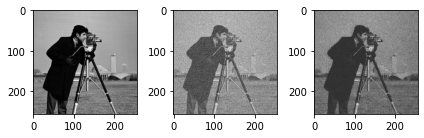

In [ ]:
plt.figure(figsize= (15, 15))

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(img1 , cmap='gray')


axarr[1].imshow(img1_nois_saved[0] , cmap='gray')

axarr[2].imshow(img1_NLF2_saved[0] , cmap='gray' )

f.tight_layout()    
plt.show()

La figure ci-dessous (au milieu est bruité avec $\sigma = 30$ ) et celle qui est à droite est celle débruitée par notre NLF

$\sigma = 50$

<Figure size 1080x1080 with 0 Axes>

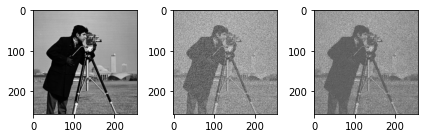

In [ ]:
plt.figure(figsize= (15, 15))

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(img1 , cmap='gray')


axarr[1].imshow(img1_nois_saved[1] , cmap='gray')

axarr[2].imshow(img1_NLF2_saved[1] , cmap='gray' )

f.tight_layout()    
plt.show()

$\sigma = 75$

<Figure size 1080x1080 with 0 Axes>

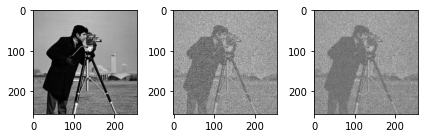

In [ ]:
plt.figure(figsize= (15, 15))

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(img1 , cmap='gray')


axarr[1].imshow(img1_nois_saved[2] , cmap='gray')

axarr[2].imshow(img1_NLF2_saved[2] , cmap='gray' )

f.tight_layout()    
plt.show()

### Result NLF image 1 (for 5 runs)

In [ ]:
Sigmas = [30, 50, 75]
Avg_PSNR = list(results_nlf.mean(axis = 1))
max_PSNR  = list(results_nlf.max(axis = 1))
std_PSNR  = list(results_nlf.std(axis = 1))
data_NLF = pd.DataFrame({'sigma': Sigmas, ' avg PSNR ': Avg_PSNR, 'max PSNR': max_PSNR, 'std PSNR': std_PSNR })

In [ ]:
data_NLF

,sigma,avg PSNR,max PSNR,std PSNR
0,30,15.740179,15.756301,0.014547
1,50,14.198071,14.216281,0.017254
2,75,11.904288,11.941461,0.021177


## FFDNet only

In [ ]:
n_runs = 5 #1 #5
sigmas = [30/255., 50/255., 75/255.] # [30/255.] #
img1_nois_saved = []
img1_FFDnet_saved = []
results_ffdnet = np.zeros( (len(sigmas), n_runs) )



for ind_sigma , sigma in enumerate(sigmas):
  print('sigma = %s'%sigma)
  for r in range(n_runs):
    print('run %s'%r)
    np.random.seed(r) # for the sake of reproductibility
    img1_nois = img1  + sigma*np.random.randn(img.shape[0], img.shape[1] )
    img1_ffdnet = test_ffdnet(img1_nois, sigma, cuda = use_cuda )  #    
    img1_ffdnet = img1_ffdnet.data.cpu().numpy().reshape((256, 256))        
    if r == 0: # we save the noisy image and the denoised image for visualization 
      img1_nois_saved.append(img1_nois)
      img1_FFDnet_saved.append(img1_ffdnet)
    results_ffdnet[ind_sigma, r] = compare_psnr(img1, img1_ffdnet)


### $\sigma = 30$

<Figure size 1080x1080 with 0 Axes>

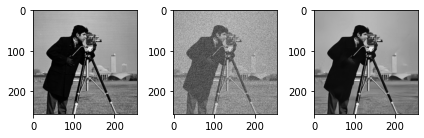

In [ ]:
plt.figure(figsize= (15, 15))

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(img1 , cmap='gray')


axarr[1].imshow(img1_nois_saved[0] , cmap='gray')

axarr[2].imshow(img1_FFDnet_saved[0] , cmap='gray' )

f.tight_layout()    
plt.show()

### $\sigma = 50$

<Figure size 1080x1080 with 0 Axes>

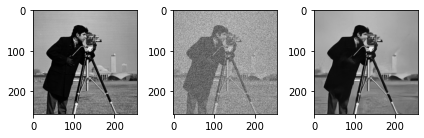

In [ ]:
plt.figure(figsize= (15, 15))

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(img1 , cmap='gray')


axarr[1].imshow(img1_nois_saved[1] , cmap='gray')

axarr[2].imshow(img1_FFDnet_saved[1] , cmap='gray' )

f.tight_layout()    
plt.show()

### $\sigma = 75$

<Figure size 1080x1080 with 0 Axes>

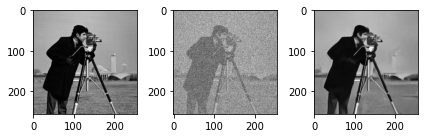

In [ ]:
plt.figure(figsize= (15, 15))

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(img1 , cmap='gray')


axarr[1].imshow(img1_nois_saved[2] , cmap='gray')

axarr[2].imshow(img1_FFDnet_saved[2] , cmap='gray' )

f.tight_layout()    
plt.show()

### Quantitative  result FFDnet  (5 runs)

In [ ]:
Sigmas = [30, 50, 75]
Avg_PSNR = list(results_ffdnet.mean(axis = 1))
max_PSNR  = list(results_ffdnet.max(axis = 1))
std_PSNR  = list(results_ffdnet.std(axis = 1))
data_FFDNet = pd.DataFrame({'sigma': Sigmas, ' avg PSNR ': Avg_PSNR, 'max PSNR': max_PSNR, 'std PSNR': std_PSNR })

In [ ]:
data_FFDNet

,sigma,avg PSNR,max PSNR,std PSNR
0,30,29.312170,29.390504,0.055645
1,50,27.191246,27.343425,0.101102
2,75,25.507663,25.711602,0.128276


## NN3D (FFDnet + NLF)

In [ ]:
n_runs = 5 #1 #5
sigmas = [30/255., 50/255., 75/255.] # [30/255.] #
img1_nois_saved = []
img1_nn3d_saved = []
results_nn3d = np.zeros( (len(sigmas), n_runs) )

times = np.zeros( (len(sigmas), n_runs) )



for ind_sigma , sigma in enumerate(sigmas):
  print('sigma = %s'%sigma)
  for r in range(n_runs):
    print('run %s'%r)
    np.random.seed(r) # for the sake of reproductibility
    img1_nois = img1  + sigma*np.random.randn(img.shape[0], img.shape[1] )
    start = time.time()
    img1_nn3d = nn3d(img1_nois, K= 2,  sigma = sigma, verbose= False) 
    end = time.time()-start 
    if r == 0: # we save the noisy image and the denoised image for visualization 
      img1_nois_saved.append(img1_nois)
      img1_nn3d_saved.append(img1_nn3d)
    results_nn3d[ind_sigma, r] = compare_psnr(img1, img1_nn3d)
    times[ind_sigma, r] = end


sigma = 0.11764705882352941
run 0
run 1
run 2
run 3
run 4
sigma = 0.19607843137254902
run 0
run 1
run 2
run 3
run 4
sigma = 0.29411764705882354
run 0
run 1
run 2
run 3
run 4


In [ ]:
results_nn3d

array([[29.3215807 , 29.22974864, 29.19024827, 29.26940499, 29.17938906],
       [27.2548146 , 27.06065145, 27.01561123, 27.16037717, 26.96902116],
       [25.57123607, 25.26748579, 25.26698048, 25.52317707, 25.28118729]])

### $\sigma = 30$

<Figure size 1080x1080 with 0 Axes>

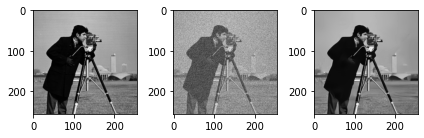

In [ ]:
plt.figure(figsize= (15, 15))

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(img1 , cmap='gray')


axarr[1].imshow(img1_nois_saved[0] , cmap='gray')

axarr[2].imshow(img1_nn3d_saved[0] , cmap='gray' )

f.tight_layout()    
plt.show()

### $\sigma = 50$

<Figure size 1080x1080 with 0 Axes>

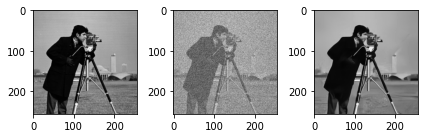

In [ ]:
plt.figure(figsize= (15, 15))

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(img1 , cmap='gray')


axarr[1].imshow(img1_nois_saved[1] , cmap='gray')

axarr[2].imshow(img1_nn3d_saved[1] , cmap='gray' )

f.tight_layout()    
plt.show()

### $\sigma = 75$

<Figure size 1080x1080 with 0 Axes>

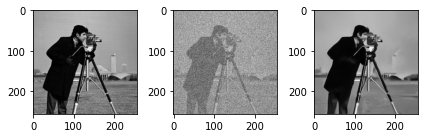

In [ ]:
plt.figure(figsize= (15, 15))

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(img1 , cmap='gray')


axarr[1].imshow(img1_nois_saved[2] , cmap='gray')

axarr[2].imshow(img1_nn3d_saved[2] , cmap='gray' )

f.tight_layout()    
plt.show()

In [ ]:
Sigmas = [30, 50, 75]
Avg_PSNR = list(results_nn3d.mean(axis = 1))
max_PSNR  = list(results_nn3d.max(axis = 1))
std_PSNR  = list(results_nn3d.std(axis = 1))

Avg_time = list(times.mean(axis = 1))
max_time  = list(times.max(axis = 1))
std_time = list(times.std(axis = 1))

times


data_nn3d = pd.DataFrame({'sigma': Sigmas, ' avg PSNR ': Avg_PSNR, 'max PSNR': max_PSNR, 'std PSNR': std_PSNR,
                          'avg time':Avg_time, 'max time': max_time, 'std time': std_time})

In [ ]:
data_nn3d

,sigma,avg PSNR,max PSNR,std PSNR,avg time,max time,std time
0,30,29.238074,29.321581,0.052451,97.073800,97.522561,0.256906
1,50,27.092095,27.254815,0.103078,97.231562,97.412398,0.104664
2,75,25.382013,25.571236,0.135829,96.668727,97.241491,0.317214


# Support visuel des images débuitées par nos modèles pour $\sigma = 30$

Noisy image

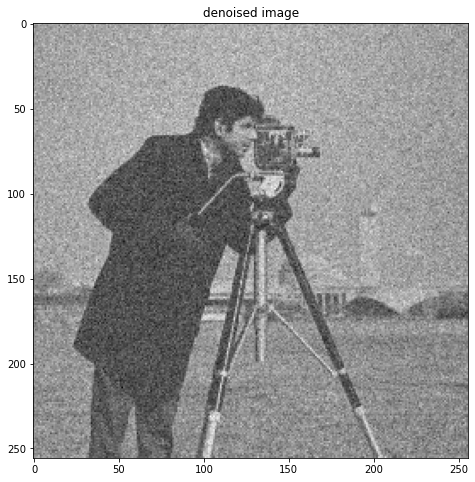

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(img1_nois_saved[0] , cmap='gray')
plt.title('denoised image')
plt.show()

NLF

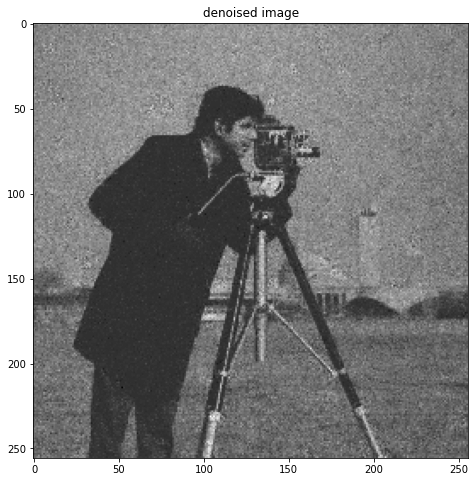

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(img1_NLF2_saved[0] , cmap='gray')
plt.title('denoised image')
plt.show()

FFDnet 

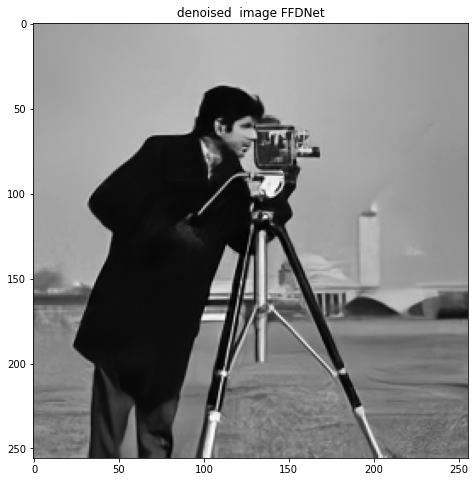

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(img1_FFDnet_saved[0], cmap='gray')
plt.title('denoised  image FFDNet')
plt.show()

NN3D (FFDnet + NLF)

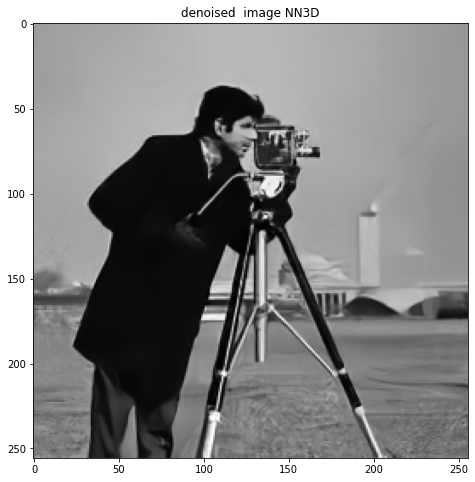

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(img1_nn3d_saved[0], cmap='gray')
plt.title('denoised  image NN3D')
plt.show()

True image 1

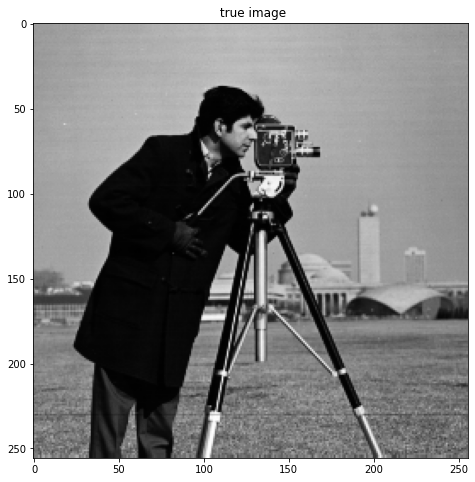

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(img1, cmap='gray')
plt.title(' true image')
plt.show()

Les  résultats qualitatifs montrent qu'il n'y a pas de différence  significative entre les images estimées par le FFDNet et le NN3D. 
On peut constater quand même constater qu'il y a quelques artifacts dans le débruitage. 


Ainsi on pense tester nos modèles sur d'autres images notamment celles Urban100.